In [2]:
%load_ext rqalpha

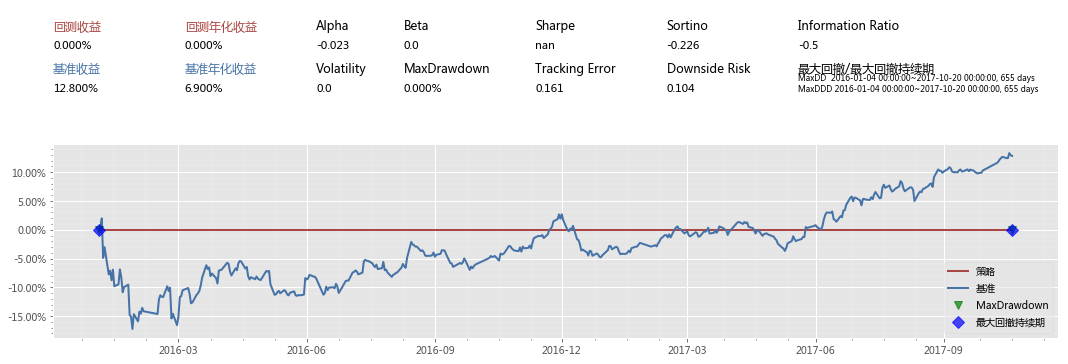

In [4]:
%rqalpha -s 20160101 -e 20171020 --account future 15000 -fq 1d -p -bm J88
# 上述命令参数可以通过运行 %%rqalpha -h 查看到
 
import talib    
    
def init(context):
    # 策略初始化运行
    context.s1 = 'J88'    # 标的为 J88
    context.AvgLen1 = 6    # 均线周期参数
    context.AvgLen2 = 12    # 长均线周期参数
    context.AvgLen3 = 28    # 更长均线周期参数
    context.RLength = 4    # 止损均线周期参数
    context.High = 0.0
    context.Low = 0.0
    
def before_trading(context):
    # 每日开盘前运行
    pass
 
def get_data(context, bar_dict):
    # 每个 bar 数据运行
    # 取出数据
    Data = history_bars(context.s1, context.AvgLen3, 
                        '1d', ['close', 'high', 'low'], 
                        skip_suspended=True, include_now=False)  
    Close = Data['close']
    Range = Data['high'] - Data['low']   # 计算振幅
    
    High = Data['high'][-1]
    Low = Data['low'][-1]
    
    EMA1 = talib.EMA(Close, context.AvgLen1)[-1]
    EMA2 = talib.EMA(Close, context.AvgLen2)[-1]
    EMA3 = talib.EMA(Close, context.AvgLen3)[-1]
    RangeL = talib.SMA(Range[-context.RLength:], context.RLength)[-1]

    return EMA1, EMA2, EMA3, RangeL, High, Low
    
    
def handle_bar(context, bar_dict):
    # 每个 bar 数据运行
    
    BuyQty=context.portfolio.positions[context.s1].buy_quantity    # 多头持仓
    SellQty=context.portfolio.positions[context.s1].sell_quantity    # 空头持仓
    
    EMA1, EMA2, EMA3, RangeL, High, Low = get_data(context, bar_dict)
    
    if EMA1 > EMA2 > EMA3: 
        if BuyQty == 0:
            buy_open(context.s1, 1)
            context.Low = Low
            print('进场，多头开仓')
            
    if (EMA1 < EMA2) or (EMA1 < (context.Low + RangeL)):
        if BuyQty > 0:    
            sell_close(context.s1, 1)
            print('出场，多头平仓')
            
    if EMA1 < EMA2 < EMA3:
        if SellQty == 0:
            sell_open(context.s1, 1)
            context.High = High
            print('进场，空头开仓')
    
    if (EMA1 > EMA2) or (EMA1 > (context.High - RangeL)):
        if SellQty > 0:
            buy_close(context.s1, 1)
            print('出场，空头平仓')        
        
 
def after_trading(context):
    # 每日收盘后运行
    pass